# TP 1

In [15]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

### 1. Preprocessing

Importing data

In [ ]:
df = pd.read_csv('Data/breast.csv', na_values='?')

df.head()

Missing values

In [16]:
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        df[column] = df[column].fillna(df[column].mean())
    else:
        df[column] = df[column].fillna(df[column].mode()[0])

df.isnull().sum().sum()

0

Encoding data (One hot encoding)

In [ ]:
attribt = ''

ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas').fit(df[[attribt]])
df = ohe.transform(df[[attribt]])

Scalling data

In [17]:
scaler = StandardScaler()

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.drop('diagnosis')
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,diagnosis
0,1.084203,-2.092526,1.260185,0.968905,1.642284,3.273826,2.621146,2.514512,2.186130,2.363520,2.431939,-0.548182,2.773660,2.406884,-0.181684,1.273042,0.689477,0.656891,1
1,1.827006,-0.316372,1.681730,1.900116,-0.823159,-0.477121,-0.037927,0.533630,-0.006140,-0.849484,0.474716,-0.866924,0.244343,0.706411,-0.580826,-0.677640,-0.433062,0.258702,1
2,1.573646,0.520031,1.560692,1.547688,0.997724,1.054855,1.340251,2.020129,0.922053,-0.365492,1.191951,-0.768363,0.822709,1.134102,-0.266340,0.785914,0.197068,1.416192,1
3,-0.807354,0.310930,-0.627168,-0.792948,3.407500,3.392599,1.889028,1.435623,2.829003,5.093991,0.304723,-0.081970,0.267243,-0.297966,0.740015,2.658482,0.781504,1.108280,1
4,1.746391,-1.140757,1.773552,1.817023,0.316541,0.543945,1.347734,1.412449,-0.016975,-0.534598,1.233118,-0.778777,1.238334,1.142891,1.549180,-0.052185,0.790132,1.137298,1


### 2. Splitting data

In [18]:
def manual_train_test_split(df, target_column, test_size=0.2):
    shuffled_df = df.sample(frac=1).reset_index(drop=True)
    split_index = int(len(shuffled_df) * (1 - test_size))

    X = shuffled_df.drop(target_column, axis = 1)
    y = shuffled_df[target_column]

    X_train = X.iloc[:split_index]
    y_train = y.iloc[:split_index]

    X_test = X.iloc[split_index:]
    y_test = y.iloc[split_index:]

    return X_train, y_train, X_test, y_test

In [19]:
X_train, y_train, X_test, y_test = manual_train_test_split(df, 'diagnosis', test_size=0.2)

In [20]:
y_train.head()

0    0
1    0
2    1
3    0
4    1
Name: diagnosis, dtype: int64

### 3. Algorithm

KNN algorithm function

In [21]:
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        predictions = []
        distances = []
        
        for _, x_test in X_test.iterrows():
            for _, x_train in self.X_train.iterrows():
                distances.append(self._distance(x_test.values, x_train.values))

            indices = np.argsort(distances)[:self.k]
            labels = [self.y_train.iloc[i] for i in indices]

            most_common = Counter(labels).most_common(1)
            predictions.append(most_common[0][0])
            distances.clear()
        

        return np.array(predictions)

    @staticmethod
    def _distance(x, y):
        return np.sqrt(np.sum((x - y) ** 2))


In [22]:
model = KNN(k=3)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [23]:
print(y_test.values)
print(predictions)

[1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0
 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1
 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1]
[1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0
 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1
 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1]


Performance evaluation for K = 1, 2, 3, 4, 5, 6, 7, 8, 9, 10

In [24]:
def performance_metrics(y_true, y_pred):
    TP = sum((y_true == 1) & (y_pred == 1))
    TN = sum((y_true == 0) & (y_pred == 0))
    FP = sum((y_true == 0) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))

    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    f_measure = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'precision': precision,
        'recall': recall,
        'f_measure': f_measure
    }     

In [25]:
precisions = []

for k in range(1, 11):
    model = KNN(k=k)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    metrics = performance_metrics(y_test.values, predictions)
    precisions.append(metrics['precision'])

    print(f"K = {k}")
    print(f"True Positives (TP): {metrics['TP']}")
    print(f"True Negatives (TN): {metrics['TN']}")
    print(f"False Positives (FP): {metrics['FP']}")
    print(f"False Negatives (FN): {metrics['FN']}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F-Measure: {metrics['f_measure']:.4f}")
    print('-' * 30) 

K = 1
True Positives (TP): 37
True Negatives (TN): 59
False Positives (FP): 1
False Negatives (FN): 3
Precision: 0.9737
Recall: 0.9250
F-Measure: 0.9487
------------------------------
K = 2
True Positives (TP): 37
True Negatives (TN): 59
False Positives (FP): 1
False Negatives (FN): 3
Precision: 0.9737
Recall: 0.9250
F-Measure: 0.9487
------------------------------
K = 3
True Positives (TP): 37
True Negatives (TN): 59
False Positives (FP): 1
False Negatives (FN): 3
Precision: 0.9737
Recall: 0.9250
F-Measure: 0.9487
------------------------------
K = 4
True Positives (TP): 37
True Negatives (TN): 60
False Positives (FP): 0
False Negatives (FN): 3
Precision: 1.0000
Recall: 0.9250
F-Measure: 0.9610
------------------------------
K = 5
True Positives (TP): 36
True Negatives (TN): 59
False Positives (FP): 1
False Negatives (FN): 4
Precision: 0.9730
Recall: 0.9000
F-Measure: 0.9351
------------------------------
K = 6
True Positives (TP): 36
True Negatives (TN): 60
False Positives (FP): 0
Fa

Precision curve

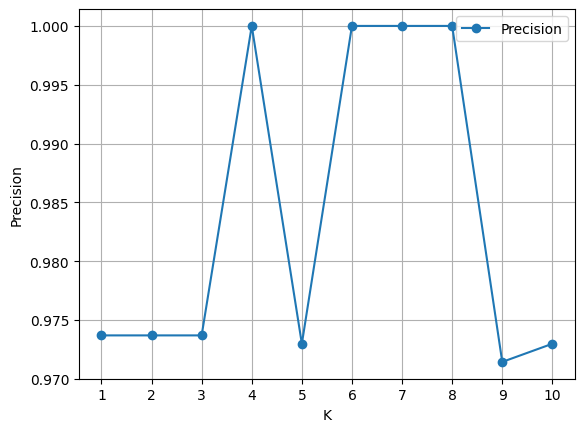

In [26]:
plt.plot(range(1, 11), precisions, marker='o', label='Precision')
plt.xlabel('K')
plt.ylabel('Precision')
plt.xticks(range(1, 11, 1))
plt.legend()
plt.grid()
plt.show()


Best K is **3**